In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker-nomadiq-data'
data_key = 'instagram_df.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

In [2]:
%matplotlib inline

import json
import os
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import re
from datetime import datetime
import itertools
from collections import Counter
from sklearn import preprocessing
from sklearn.feature_extraction.text import *

# EDA

In [3]:
# Get top 5 rows
df.head()

,caption,location_id,location_name,timestamp,hashtags,month,datetime_readable
0,Hair kissed by the sun ☀\n••••••••••••••••••••...,NaN,NaN,1.548702e+09,"['ad', 'playrescuereset', 'pantenerescueshots']",1.0,1970-01-01 00:00:01.548701796
1,One of my favorite views in the world 🗺 ••••••...,215871574.0,"Cape Town, Western Cape",1.548620e+09,['mavic2pro'],1.0,1970-01-01 00:00:01.548620093
2,Got my sights set on Sydney! 🐨🇦🇺 •••••••••••••...,2112249.0,Sydney Opera House,1.548445e+09,"['sydney', 'australia']",1.0,1970-01-01 00:00:01.548445014
3,Planning a bucket list trip in 2019? #CapitalO...,NaN,NaN,1.548181e+09,['capitalonepartner'],1.0,1970-01-01 00:00:01.548180883
4,Back home in my favorite city ♥️🇿🇦\n••••••••••...,215871574.0,"Cape Town, Western Cape",1.548102e+09,"['capetown', 'southafrica', 'tbapresets']",1.0,1970-01-01 00:00:01.548101892


In [4]:
# Unique locations
print("There are", len(df.location_name.unique()), "unique location strings")

There are 69712 unique location strings


Text(0.5,1,'Cumulative Distribution of Most Popular Destinations')

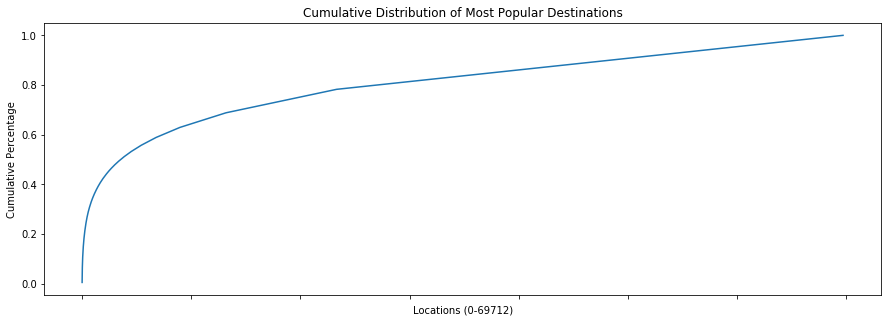

In [5]:
# Distribution of location popularity

locations = pd.DataFrame({'location': range(len(df.location_name.value_counts())),'count': df.location_name.value_counts(), 'cumulative_count': df.location_name.value_counts().cumsum()})
locations['cum_perc'] = locations.cumulative_count/df.location_name.value_counts().sum()
locations[:1000]

fig, ax = plt.subplots(figsize = (15,5))

locations['cum_perc'].plot(kind = "line")
ax.set_xlabel("Locations (0-69712)")
ax.set_ylabel("Cumulative Percentage")
ax.set_title("Cumulative Distribution of Most Popular Destinations")

Text(0.5,1,'Most Popular Travel Destinations')

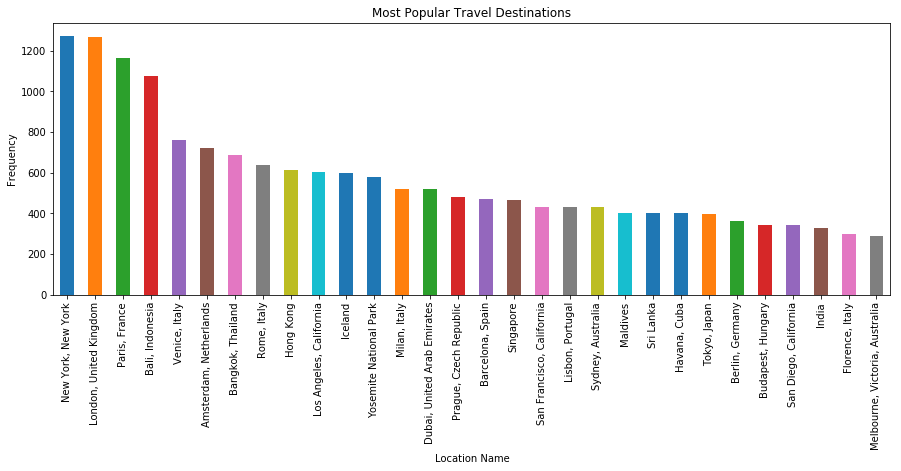

In [6]:
# Get most popular travel destinations
fig, ax = plt.subplots(figsize = (15,5))

df.location_name.value_counts()[:30].plot(kind = "bar")
ax.set_xlabel("Location Name")
ax.set_ylabel("Frequency")
ax.set_title("Most Popular Travel Destinations")

In [7]:
# Unravel hashtags
import ast
hashtags = []
for sublist in df['hashtags']:
    try:
        for val in ast.literal_eval(sublist):
            hashtags.append(val)    
    except:
        pass


Text(0.5,1,'Most Popular Hashtags')

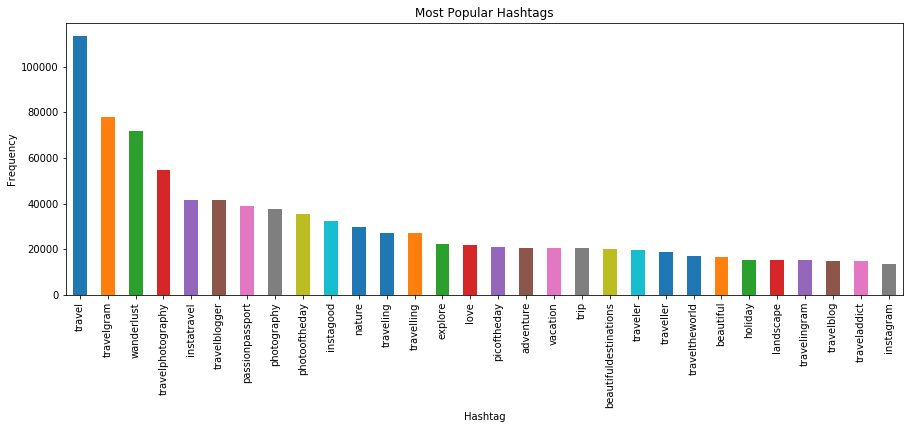

In [8]:
# Get most common hashtags
fig, ax = plt.subplots(figsize = (15,5))

pd.DataFrame(hashtags,columns = ['hashtag']).hashtag.value_counts()[:30].plot(kind = "bar")
ax.set_xlabel("Hashtag")
ax.set_ylabel("Frequency")
ax.set_title("Most Popular Hashtags")

Text(0.5,1,'Posts by Month')

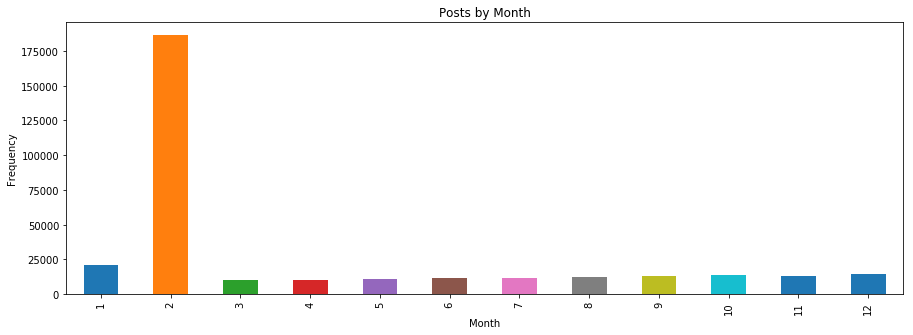

In [11]:
month_posts = df.month.value_counts()
month_posts.index = month_posts.index.map(int)
month_posts.sort_index()

fig, ax = plt.subplots(figsize = (15,5))

month_posts.sort_index().plot(kind = "bar",sort_columns=True)
ax.set_xlabel("Month")
ax.set_ylabel("Frequency")
ax.set_title("Posts by Month")

In [12]:
from lxml import html
import requests

location_ids = instagram_df.location_id.unique()[1:]
# print(len(location_ids))
lat_long = []

for i, loc_id in enumerate(location_ids):
    print(i,":loc id - ",loc_id,end="\r")
    try:
        page = requests.get('https://www.instagram.com/explore/locations/'+str(loc_id))
        posts = str(page.content).split('LocationsPage')[1]
        loc = str(posts.split(']')[0]).split(',"blurb"')[0]
        loc = loc.replace('":[{"graphql":','') + "}}"
        loc_json = json.loads(loc)
        lat_long.append([loc_json['location']['lat'],loc_json['location']['lng']])
    except:
        lat_long.append("Location ID Error")
    
loc_geo_map = pd.DataFrame({"loc_id":location_ids},{"lat_long": np.array(lat_long)})
loc_geo_map.head()

NameError: name 'instagram_df' is not defined

# Text Analysis

There are multiple functions here to clean up the data for ingestion into our model. There are a set of regex rules that normalize our strings. Once we load the data, we concatenate all the text data and apply our regex rules. We use Pandas to load the data (probably not optimal, but it's higher level and requires fewer lines of code). We use Sklearn's preprocessing package to encode our labels (in this case, our labels are location). All input text (x) is padded to equal the longest sentence length to feed into our neural net. Each of the input words are indexed and an input matrix (num of examples by max sentence length) is created. The inputs (x) and outputs (y) are shuffled and separated into training and test sets.

Areas of improvement:

Regex rules are not comprehensive. These may still result in words that make no sense or extraneous words. Keep in mind that catalog data is different from normal language. There will be a lot of gibberish (i.e. model numbers, made-up words for brands, etc.). Therefore, we have a very large vocabulary. With a large vocab relative to training examples, we could be susceptible to overfitting.

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"<b>", " ", string)
    string = re.sub(r"</b>", " ", string)
    string = re.sub(r"<br>", " ", string)
    string = re.sub(r"</br>", " ", string)
    string = re.sub(r"<p>", " ", string)
    string = re.sub(r"</p>", " ", string)
    string = re.sub(r"<ul>", " ", string)
    string = re.sub(r"</ul>", " ", string)
    string = re.sub(r"<li>", " ", string)
    string = re.sub(r"</li>", " ", string)    
    return string.strip().lower()

def load_data_and_labels(dataframe):
    """
    Loads and cleans training data
    """
    # Get raw data and create concatenated text string
    
    df = dataframe.replace(np.nan, '', regex=True)
    x_text = df['caption']
    x_text = [clean_str(sent) for sent in x_text]
    x_text = [s.split(" ") for s in x_text]
    y = df['location_name']
    labelencoder = preprocessing.LabelEncoder()
    labels = labelencoder.fit_transform(y)
    return [x_text, labelencoder, labels]

def pad_sentences(sentences, padding_word="</s>"):
    """
    Pads all sentences to the same length. The length is defined by the longest sentence.
    Returns padded sentences.
    """
    sequence_length = max(len(x) for x in sentences)
    padded_sentences = []
    for i in range(len(sentences)):
        sentence = sentences[i]
        num_padding = sequence_length - len(sentence)
        new_sentence = sentence + [padding_word] * num_padding
        padded_sentences.append(new_sentence)
    return padded_sentences

def build_vocab(sentences):
    """
    Builds a vocabulary mapping from word to index based on the sentences.
    Returns vocabulary mapping and inverse vocabulary mapping.
    """
    # Build vocabulary
    word_counts = Counter(itertools.chain(*sentences))
    # Mapping from index to word
    vocabulary_inv = [x[0] for x in word_counts.most_common()]
    # Mapping from word to index
    vocabulary = {x: i for i, x in enumerate(vocabulary_inv)}
    return [vocabulary, vocabulary_inv]

def build_input_data(sentences, labels, vocabulary):
    """
    Maps sentences and labels to vectors based on a vocabulary.
    """
    x = np.array([[vocabulary[word] for word in sentence] for sentence in sentences])
    y = np.array(labels)
    return [x, y]


Train word embedding

Use text to predict location_name?
We embed the words for the captions


In [13]:
def hashtag_removal(caption):
    '''Extract hashtags from a instagram caption string'''
    try:
        return re.sub(r"#(\w+)","", caption)
    except:
        pass

df['caption_no_hashtag'] = df['caption'].apply(hashtag_removal)

In [50]:
vectorizer = CountVectorizer(stop_words= 'english',token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z][a-zA-Z]+\b')
features = vectorizer.fit_transform(df[(df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])



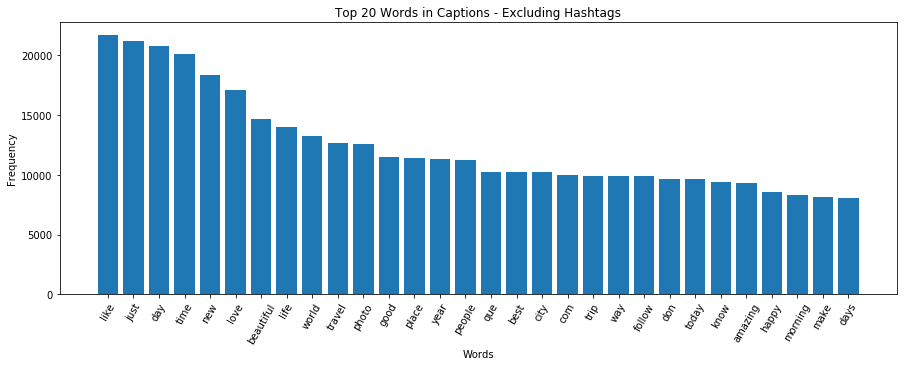

In [54]:
counts = list(zip(vectorizer.get_feature_names(),np.asarray(features.sum(axis=0))[0]))
top20 = sorted(counts, key=lambda tup: tup[1],reverse=True)[:30]


plt.figure(figsize=(15,5))
objects = ([word[0] for word in top20])
y_pos = np.arange(len(objects))
height = ([word[1] for word in top20])
plt.bar(y_pos, height, align='center')
plt.xticks(y_pos, objects, rotation = 60)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Captions - Excluding Hashtags')
plt.show()

In [52]:
locations[:10]

,count,cumulative_count,location,cum_perc
"New York, New York",1273,1273,0,0.005958
"London, United Kingdom",1265,2538,1,0.011879
"Paris, France",1165,3703,2,0.017332
"Bali, Indonesia",1077,4780,3,0.022372
"Venice, Italy",761,5541,4,0.025934
"Amsterdam, Netherlands",720,6261,5,0.029304
"Bangkok, Thailand",688,6949,6,0.032524
"Rome, Italy",636,7585,7,0.035501
Hong Kong,611,8196,8,0.038361
"Los Angeles, California",604,8800,9,0.041188


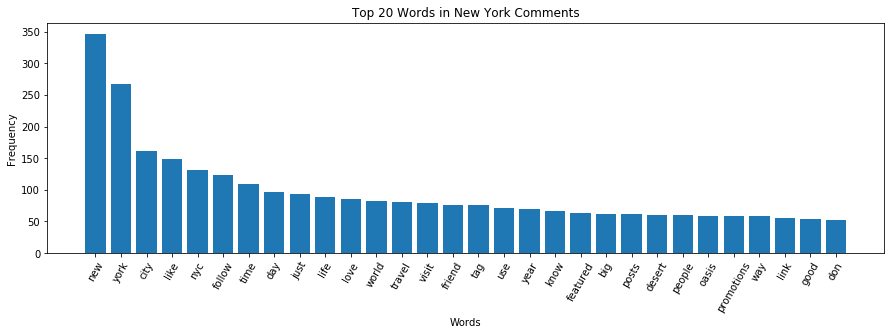

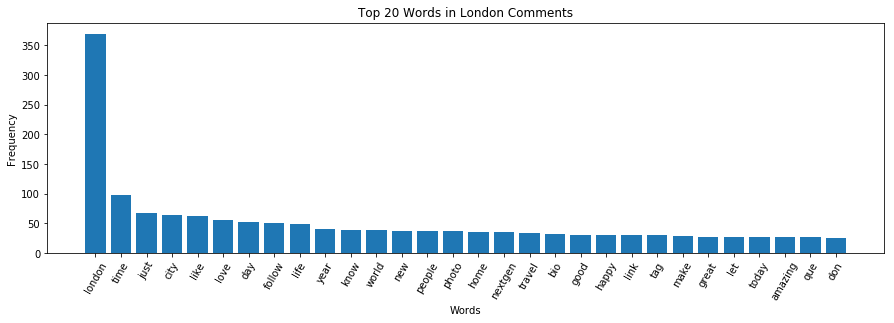

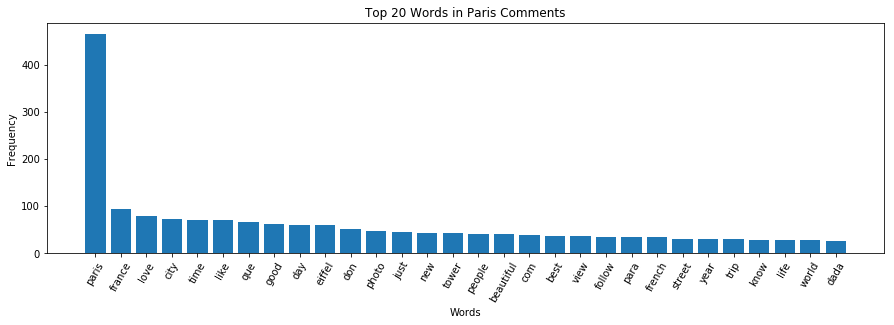

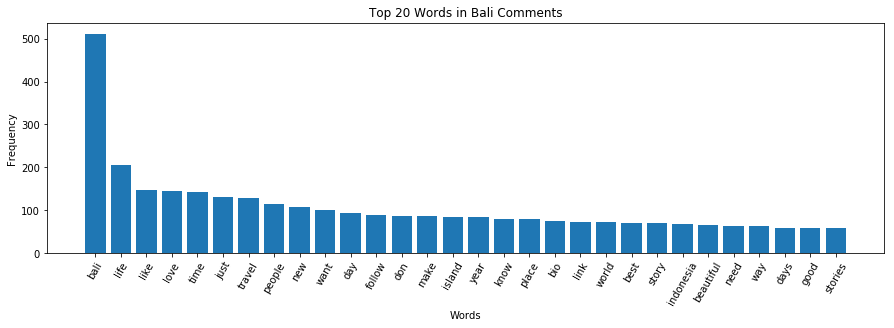

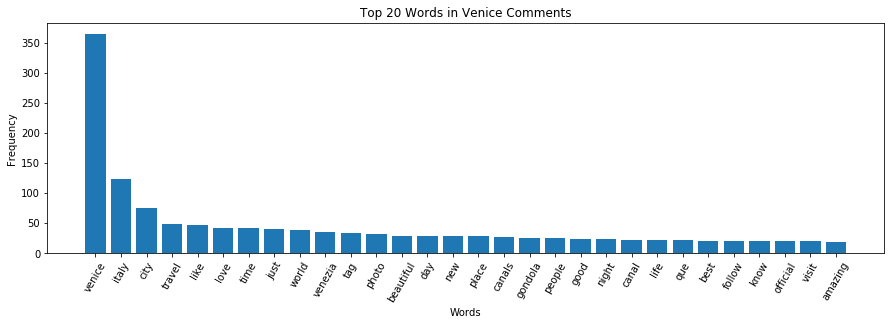

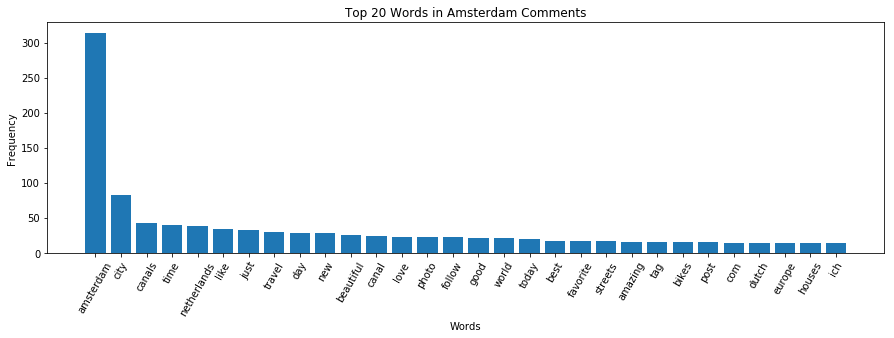

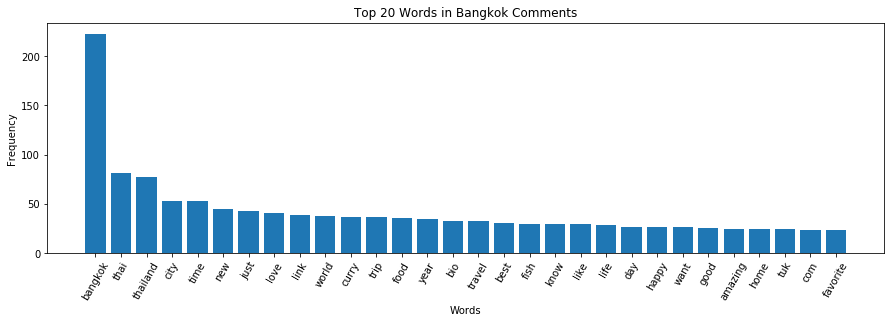

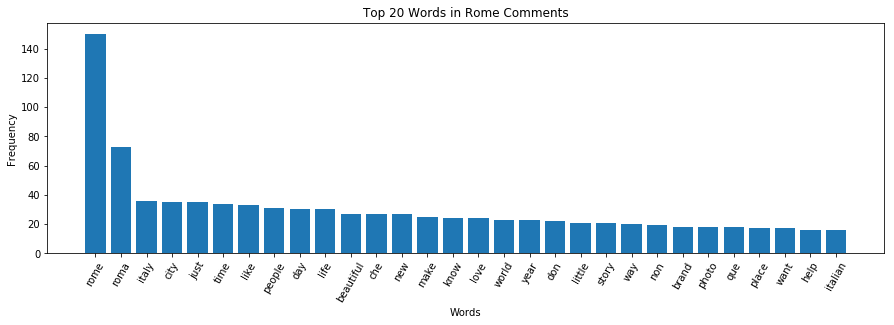

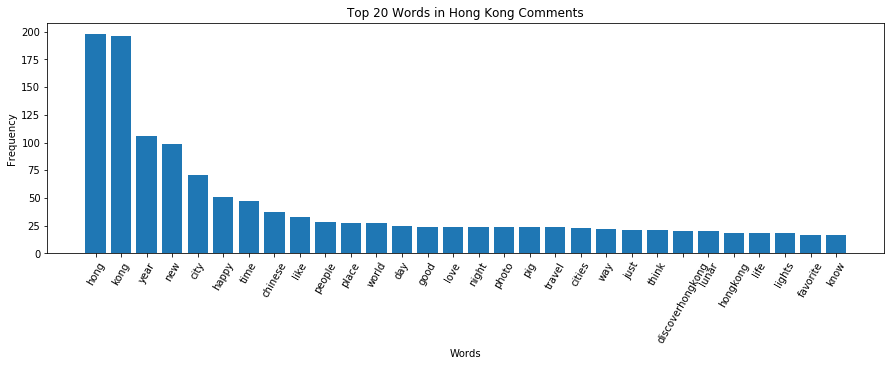

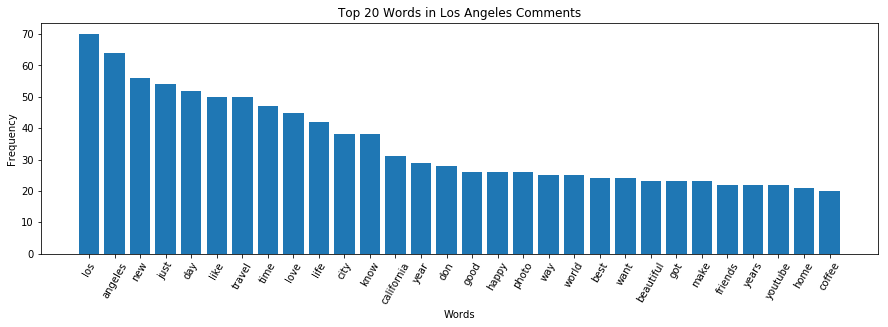

In [53]:
#Get most top 20 most common words for different types of tags
features_newyork = vectorizer.transform(df[(df.location_name == 'New York, New York') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_london = vectorizer.transform(df[(df.location_name == 'London, United Kingdom') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_paris = vectorizer.transform(df[(df.location_name == 'Paris, France') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_bali = vectorizer.transform(df[(df.location_name == 'Bali, Indonesia') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_venice = vectorizer.transform(df[(df.location_name == 'Venice, Italy') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_amsterdam = vectorizer.transform(df[(df.location_name == 'Amsterdam, Netherlands') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_bangkok = vectorizer.transform(df[(df.location_name == 'Bangkok, Thailand') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_rome = vectorizer.transform(df[(df.location_name == 'Rome, Italy') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_hongkong = vectorizer.transform(df[(df.location_name == 'Hong Kong') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])
features_losangeles = vectorizer.transform(df[(df.location_name == 'Los Angeles, California') & (df.caption_no_hashtag.notnull()) & (df.caption_no_hashtag != True) & (df.caption_no_hashtag != False)]['caption_no_hashtag'])

classes = [features_newyork,features_london, features_paris,features_bali,
           features_venice,features_amsterdam,features_bangkok,features_rome,
          features_hongkong,features_losangeles]
class_names = ['New York', 'London', 'Paris', 'Bali', 'Venice', 'Amsterdam', 
               'Bangkok', 'Rome', 'Hong Kong', 'Los Angeles']

counts = list(zip(vectorizer.get_feature_names(),np.asarray(features.sum(axis=0))[0]))
top20 = sorted(counts, key=lambda tup: tup[1],reverse=True)[:30]

for k in range(len(classes)):
    counts = list(zip(vectorizer.get_feature_names(),np.asarray(classes[k].sum(axis=0))[0]))
    top20 = sorted(counts, key=lambda tup: tup[1],reverse=True)[:30]
    
    plt.figure(figsize=(15,50))
    plt.subplot(10, 1, k+1)
    objects = ([word[0] for word in top20])
    y_pos = np.arange(len(objects))
    height = ([word[1] for word in top20])
    plt.bar(y_pos, height, align='center')
    plt.xticks(y_pos, objects, rotation = 60)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 20 Words in ' + class_names[k] + ' Comments')
    plt.show()